In [10]:
import numpy as np
import matplotlib.pyplot as plt
from math import cos, sin, pi
from abc import abstractmethod, ABC

In [11]:
def TMA(a, b, c, d):
    n = len(d)
    P = [0]*(n)
    Q = [0]*(n)
    P[0] = -c[0] / b[0]
    Q[0] = d[0] / b[0]
    for i in range(1, n - 1):
        denom = (b[i] + a[i]*P[i - 1])
        P[i] = -c[i] / denom
        Q[i] = (d[i] - a[i]*Q[i - 1]) / denom
    P[-1] = 0
    Q[-1] = (d[-1] - a[-1]*Q[-2])/(b[-1] + a[-1]*P[-2])
    x = [0]*n
    x[-1] = Q[-1]
    for i in range(n - 2, -1, -1):
        x[i] = P[i]*x[i + 1] + Q[i]
    return np.array(x)

In [12]:
class ParabolicEquation(ABC):
    @abstractmethod
    def Phi_1(self, t: float, y: float):
        pass

    @abstractmethod
    def Phi_2(self, t: float, y: float):
        pass

    @abstractmethod
    def Phi_3(self, t: float, x: float):
        pass

    @abstractmethod
    def Phi_4(self, t: float, x: float):
        pass

    @abstractmethod
    def Psi(self, x: float, y: float):
        pass

    @abstractmethod
    def U(self, t: float, x: float, y: float):
        pass

    @abstractmethod
    def f(self, t: float, x: float, y: float):
        pass

    @property
    @abstractmethod
    def l1(self):
        pass

    @property
    @abstractmethod
    def l2(self):
        pass

In [13]:
class ParabolicEquationVariant7(ParabolicEquation):
    def Phi_1(self, t: float, y: float):
        return 0

    def Phi_2(self, t: float, y: float):
        return y * cos(t)

    def Phi_3(self, t: float, x: float):
        return 0

    def Phi_4(self, t: float, x: float):
        return x * cos(t)

    def Psi(self, x: float, y: float):
        return x * y

    def U(self, t: float, x: float, y: float):
        return x * y * cos(t)

    def f(self, t: float, x: float, y: float):
        return -x * y * sin(t)

    @property
    def l1(self):
        return 1

    @property
    def l2(self):
        return 1

In [14]:
class ParabolicSolver(ABC):
    @property
    @abstractmethod
    def equation(self):
        pass

    @abstractmethod
    def solve(self):
        pass

In [15]:
def get_ranges(equation: ParabolicEquation, T: float, Nx: int, Ny: int, K: int):
    hx = equation.l1 / Nx
    hy = equation.l2 / Ny
    tau = T / K
    x0, xn = 0, equation.l1 + hx
    y0, yn = 0, equation.l2 + hy
    t0, tn = 0, T + tau
    x = np.arange(x0, xn, hx)
    y = np.arange(y0, yn, hy)
    t = np.arange(t0, tn, tau)
    return x, y, t, hx, hy, tau

In [16]:
class AnalyticSolver(ParabolicSolver):
    def __init__(self, equation: ParabolicEquation, T: float, Nx: int, Ny: int, K: int) -> None:
        self._equation = equation
        self.x, self.y, self.t, self.hx, self.hy, self.tau = get_ranges(equation, T, Nx, Ny, K)
        self.n, self.m, self.k = len(self.x), len(self.y), len(self.t)

    @property
    def equation(self):
        return self._equation

    def solve(self):
        u = np.zeros((self.k, self.n, self.m))
        for kt in range(self.k):
            for i in range(self.n):
                for j in range(self.m):
                    u[kt, i, j] = self.equation.U(self.t[kt], self.x[i], self.y[j])
        return u

In [17]:
class NumericSolverVariant7(ParabolicSolver):
    def __init__(self, equation: ParabolicEquation, T: float, Nx: int, Ny: int, K: int, gamma: int = 1) -> None:
        self._equation = equation
        self.x, self.y, self.t, self.hx, self.hy, self.tau = get_ranges(equation, T, Nx, Ny, K)
        self.n, self.m, self.k = len(self.x), len(self.y), len(self.t)
        # N = 2 (задача двумерная)
        self.N = 2
        # γ задаётся из вне, для МПН: γ = N - 1 = 1, для МДШ: γ = 0
        self._gamma = gamma  # передаётся извне, соответствуя старой логике
        # u0j_coeff, unj_coeff, ui0_coeff, uim_coeff:
        self.u0j_coeff = 2 * self.hx
        self.unj_coeff = 2 * self.hx
        self.ui0_coeff = 2 * self.hy
        self.uim_coeff = 2 * self.hy

    @property
    def equation(self):
        return self._equation

    def solve(self):
        # Инициализация
        res = np.zeros((self.n, self.m))
        for i in range(self.n):
            for j in range(self.m):
                res[i, j] = self.equation.Psi(self.x[i], self.y[j])

        answer = [res.copy()]

        for kt in range(self.k - 1):
            # Первый полушаг (по x)
            res_fraction = res.copy()

            # Применяем граничные условия (первый полушаг)
            for j in range(self.m):
                res_fraction[0, j] = (2*self.hx*self.equation.Phi_1(self.t[kt]+self.tau/2, self.y[j])) / self.u0j_coeff
                res_fraction[-1, j] = (2*self.hx*self.equation.Phi_2(self.t[kt]+self.tau/2, self.y[j])) / self.unj_coeff

            for i in range(self.n):
                res_fraction[i,0] = (2*self.hy*self.equation.Phi_3(self.t[kt]+self.tau/2, self.x[i])) / self.ui0_coeff
                res_fraction[i,-1] = (2*self.hy*self.equation.Phi_4(self.t[kt]+self.tau/2, self.x[i])) / self.uim_coeff

            # Решаем системы по x
            a_coef = 1
            b_coef = 1
            # Для первого полушага:
            A_1i = -a_coef/self.hx**2
            B_1i = (1+self._gamma)/self.tau + 2*a_coef/self.hx**2
            C_1i = -a_coef/self.hx**2

            for j in range(1, self.m - 1):
                # Формируем трёхдиагональную систему для x:
                A = np.zeros((self.n-2, self.n-2))
                for idx in range(self.n-2):
                    A[idx, idx] = B_1i
                for idx in range(self.n-3):
                    A[idx, idx+1] = C_1i
                    A[idx+1, idx] = A_1i

                # Корректировка первой и последней строки для учета второго порядка по x
                A[0,0] = B_1i
                A[0,1] = C_1i
                A[-1,-2] = A_1i
                A[-1,-1] = B_1i

                # Формируем вектор правой части
                D = np.zeros(self.n-2)
                for i in range(1, self.n-1):
                    D[i-1] = (res[i,j]*(1+self._gamma)/self.tau 
                              + b_coef*self._gamma/(self.N-1)*(res[i,j+1]-2*res[i,j]+res[i,j-1])/self.hy**2
                              + self._gamma/(self.N-1)*self.equation.f(self.t[kt]+self.tau/2, self.x[i], self.y[j])
                              + 1/self.N*(1 - self._gamma/(self.N-1))*self.equation.f(self.t[kt], self.x[i], self.y[j]))

                D[0] -= A_1i/self.u0j_coeff*2*self.hx*self.equation.Phi_1(self.t[kt]+self.tau/2, self.y[j])
                D[-1] -= C_1i/self.unj_coeff*2*self.hx*self.equation.Phi_2(self.t[kt]+self.tau/2, self.y[j])

                res_fraction[1:-1,j] = TMA(np.diag(A, -1), np.diag(A), np.diag(A, 1), D)

            # Первый полушаг завершён
            # Теперь второй полушаг (по y)
            res = res_fraction.copy()

            # Граничные условия для второго полушага:
            for j in range(self.m):
                res[0,j] = (2*self.hx*self.equation.Phi_1(self.t[kt+1], self.y[j]))/self.u0j_coeff
                res[-1,j] = (2*self.hx*self.equation.Phi_2(self.t[kt+1], self.y[j]))/self.unj_coeff

            for i in range(self.n):
                res[i,0] = (2*self.hy*self.equation.Phi_3(self.t[kt+1], self.x[i]))/self.ui0_coeff
                res[i,-1] = (2*self.hy*self.equation.Phi_4(self.t[kt+1], self.x[i]))/self.uim_coeff

            # Решаем системы по y
            A_2j = -b_coef/self.hy**2
            B_2j = (1+self._gamma)/self.tau + 2*b_coef/self.hy**2
            C_2j = -b_coef/self.hy**2

            for i in range(1, self.n - 1):
                A = np.zeros((self.m-2, self.m-2))
                for idx in range(self.m-2):
                    A[idx, idx] = B_2j
                for idx in range(self.m-3):
                    A[idx, idx+1] = C_2j
                    A[idx+1, idx] = A_2j

                A[0,0] = B_2j
                A[0,1] = C_2j
                A[-1,-2] = A_2j
                A[-1,-1] = B_2j

                D = np.zeros(self.m-2)
                for j in range(1, self.m - 1):
                    D[j-1] = (
                        res_fraction[i,j]*(1+self._gamma)/self.tau
                        + self._gamma/(self.N-1)* (res_fraction[i+1,j]-2*res_fraction[i,j]+res_fraction[i-1,j]) / self.hx**2
                        + self._gamma/(self.N-1)*self.equation.f(self.t[kt]+self.tau/2, self.x[i], self.y[j])
                        + 1/self.N*(1 - self._gamma/(self.N-1))*self.equation.f(self.t[kt+1], self.x[i], self.y[j])
                    )

                D[0] -= A_2j/self.ui0_coeff*2*self.hy*self.equation.Phi_3(self.t[kt+1], self.x[i])
                D[-1] -= C_2j/self.uim_coeff*2*self.hy*self.equation.Phi_4(self.t[kt+1], self.x[i])

                res[i,1:-1] = TMA(np.diag(A,-1), np.diag(A), np.diag(A,1), D)

            answer.append(res.copy())

        return np.array(answer)

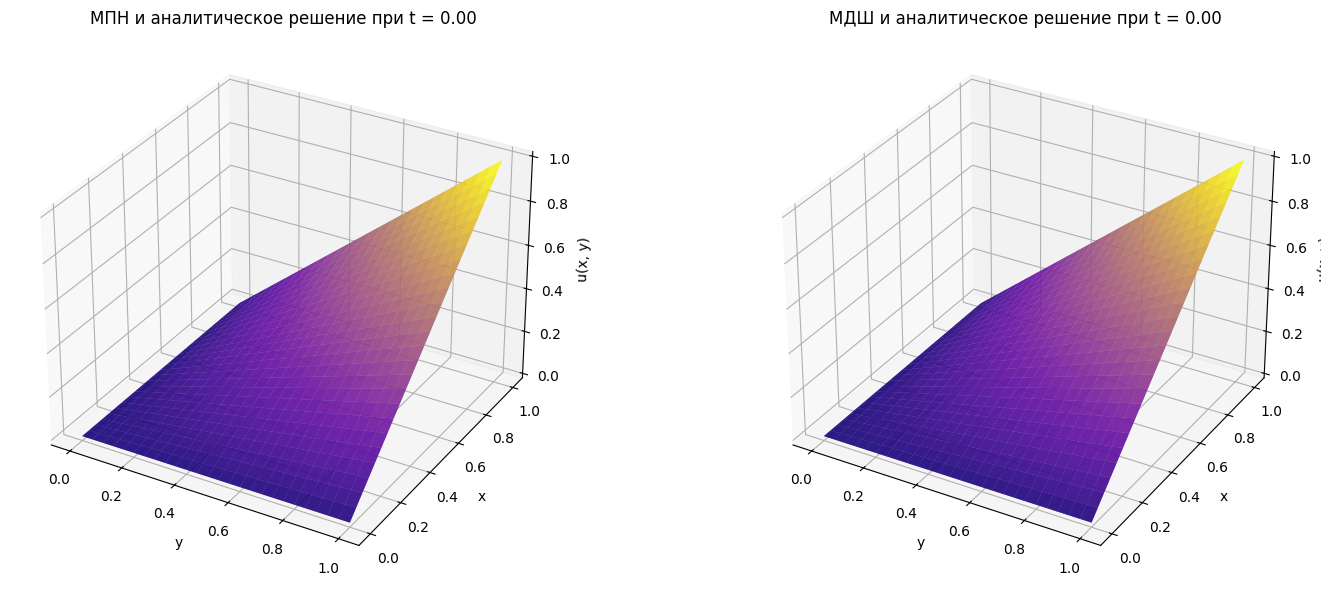

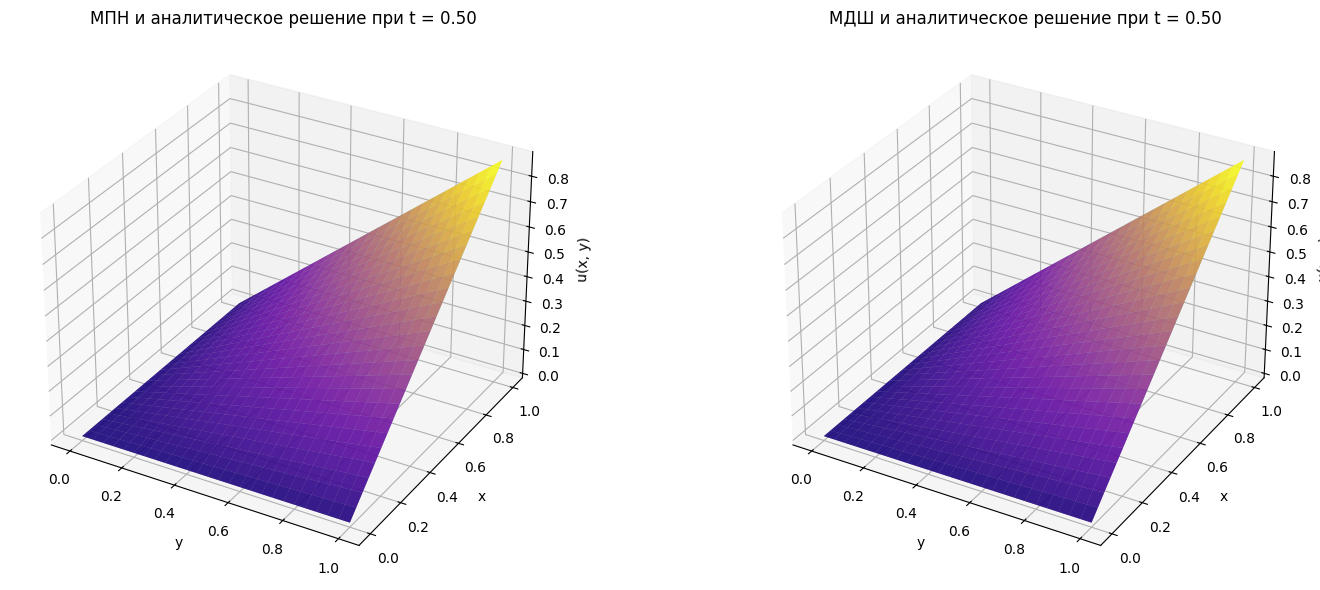

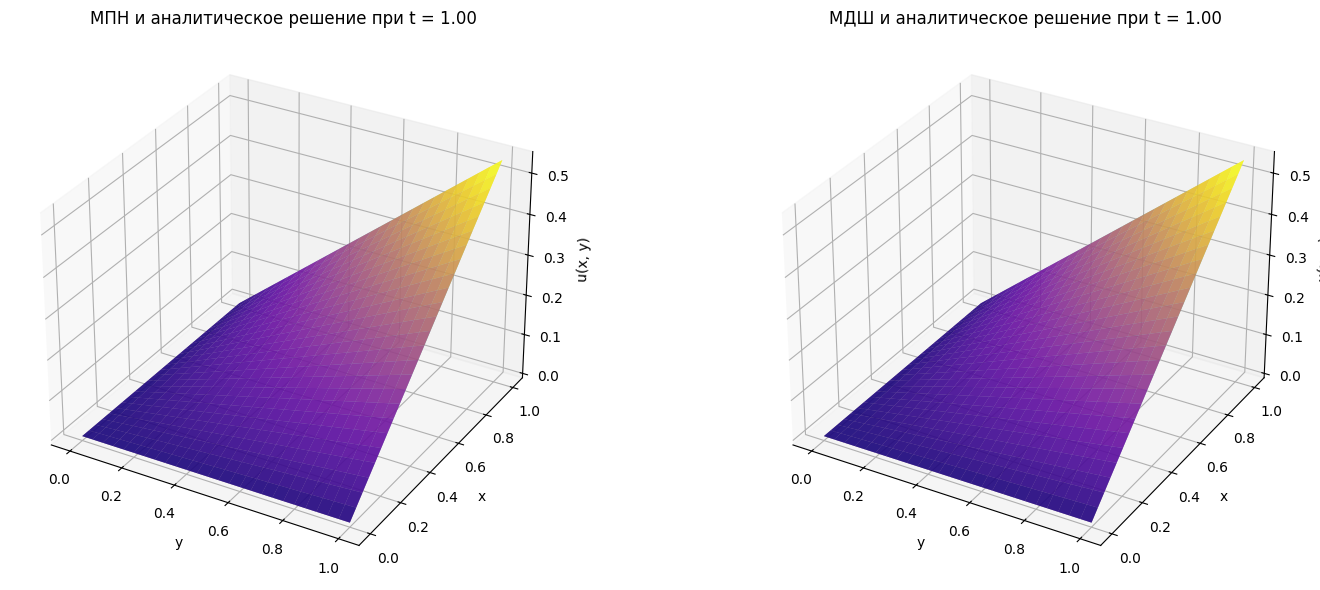

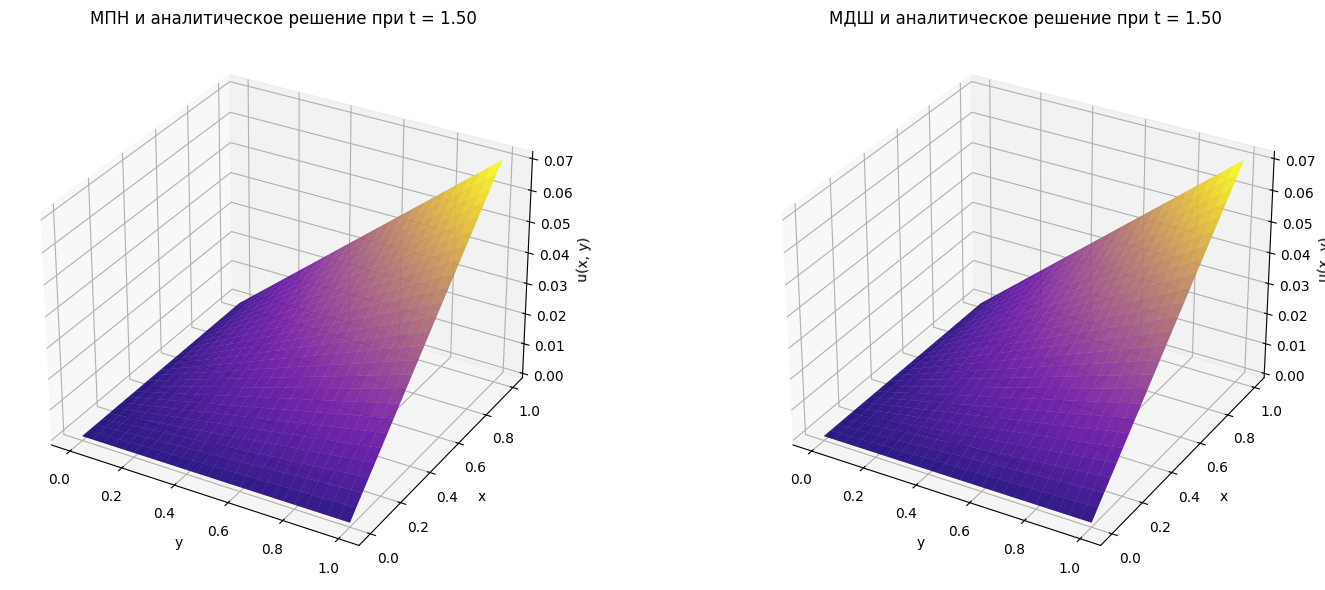

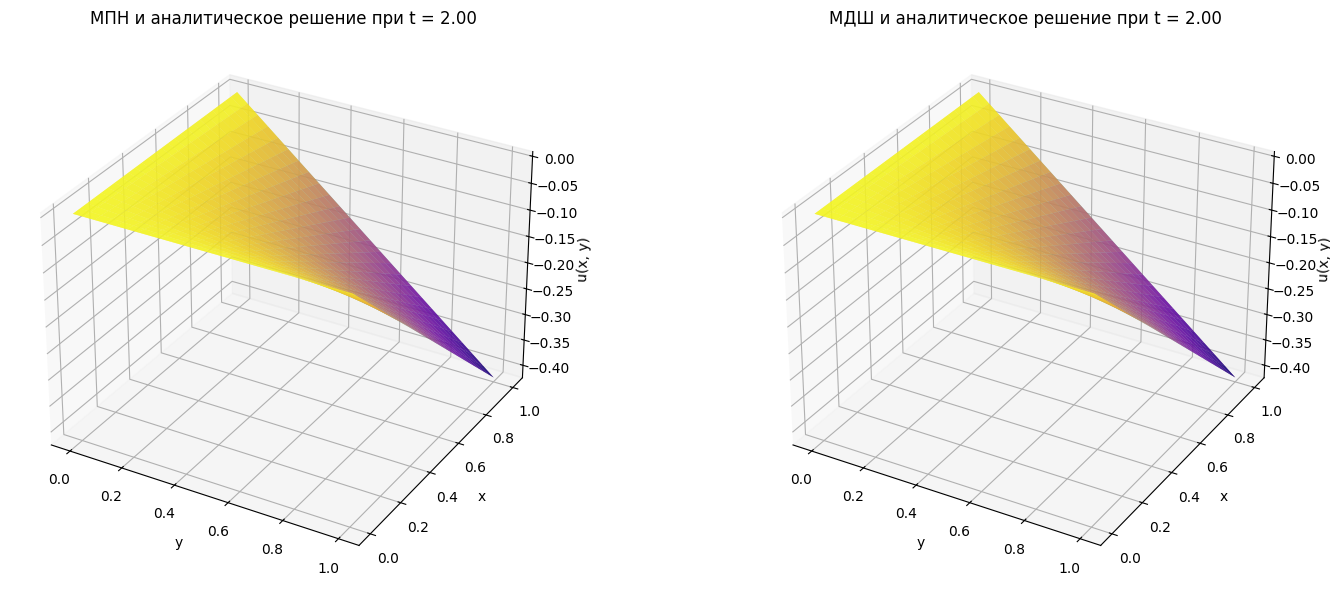

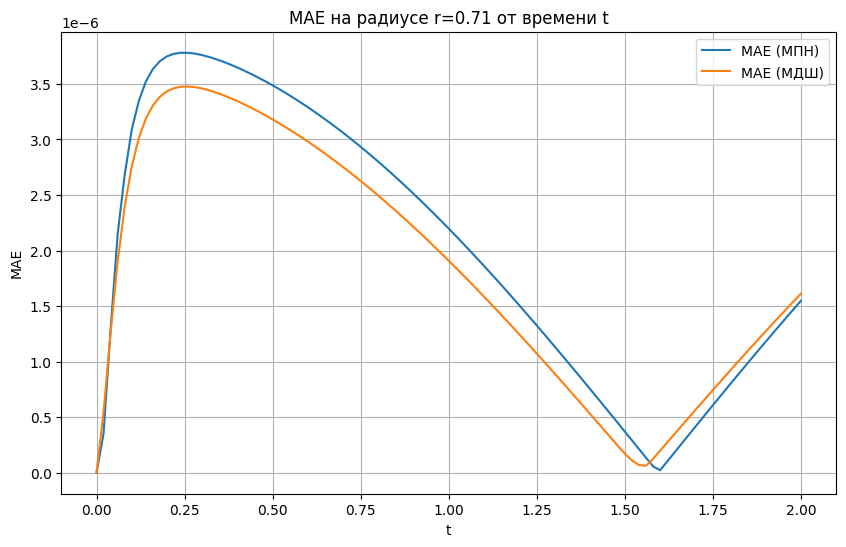

In [18]:
if __name__ == "__main__":
    T = 2
    Nx, Ny, K = 50, 50, 100
    eq = ParabolicEquationVariant7()
    analytic_solver = AnalyticSolver(eq, T=T, Nx=Nx, Ny=Ny, K=K)

    # Метод переменных направлений (МПН)
    numeric_solver_mpn = NumericSolverVariant7(eq, T=T, Nx=Nx, Ny=Ny, K=K, gamma=1)
    u_mpn = numeric_solver_mpn.solve()

    # Метод дробных шагов (МДШ)
    numeric_solver_mdsh = NumericSolverVariant7(eq, T=T, Nx=Nx, Ny=Ny, K=K, gamma=0)
    u_mdsh = numeric_solver_mdsh.solve()

    u_analytic = analytic_solver.solve()

    X, Y = np.meshgrid(analytic_solver.y, analytic_solver.x)

    # Выберем несколько моментов времени для серии 3D-графиков
    t_values = [0, T/4, T/2, 3*T/4, T]
    for t_val in t_values:
        k = np.argmin(np.abs(analytic_solver.t - t_val))
        u_t_analytic = u_analytic[k, :, :]
        u_t_mpn = u_mpn[k, :, :]
        u_t_mdsh = u_mdsh[k, :, :]

        # 3D графики
        fig = plt.figure(figsize=(16, 6))

        ax1 = fig.add_subplot(1, 2, 1, projection='3d')
        ax1.plot_surface(X, Y, u_t_analytic, cmap='viridis', alpha=0.7)
        ax1.plot_surface(X, Y, u_t_mpn, cmap='plasma', alpha=0.7)
        ax1.set_title(f"МПН и аналитическое решение при t = {analytic_solver.t[k]:.2f}")
        ax1.set_xlabel("y")
        ax1.set_ylabel("x")
        ax1.set_zlabel("u(x, y)")

        ax2 = fig.add_subplot(1, 2, 2, projection='3d')
        ax2.plot_surface(X, Y, u_t_analytic, cmap='viridis', alpha=0.7)
        ax2.plot_surface(X, Y, u_t_mdsh, cmap='plasma', alpha=0.7)
        ax2.set_title(f"МДШ и аналитическое решение при t = {analytic_solver.t[k]:.2f}")
        ax2.set_xlabel("y")
        ax2.set_ylabel("x")
        ax2.set_zlabel("u(x, y)")

        plt.tight_layout()
        plt.show()

    # Теперь построим график ошибки MAE по радиусу в зависимости от времени.
    # Выберем радиус (например, середину диагонали области)
    # Область: x от 0 до l1, y от 0 до l2 => макс. радиус ~ sqrt(l1^2 + l2^2)
    l1 = eq.l1
    l2 = eq.l2
    max_r = np.sqrt(l1**2 + l2**2)
    chosen_r = max_r / 2.0  # выбранный радиус
    delta_r = 0.05  # допуск по радиусу

    # Вычислим MAE для МПН и МДШ по выбранному радиусу
    mae_mpn = []
    mae_mdsh = []
    radius_mask = (np.sqrt(X**2 + Y**2) > (chosen_r - delta_r)) & (np.sqrt(X**2 + Y**2) < (chosen_r + delta_r))

    # Если точек мало, можно увеличить delta_r или выбрать другой радиус.
    # Будем вычислять MAE: mean(|u_num - u_analytic|)
    for kt in range(analytic_solver.k):
        diff_mpn = np.abs(u_mpn[kt,:,:] - u_analytic[kt,:,:])
        diff_mdsh = np.abs(u_mdsh[kt,:,:] - u_analytic[kt,:,:])

        # MAE по выбранному "кольцу"
        values_mpn = diff_mpn[radius_mask]
        values_mdsh = diff_mdsh[radius_mask]

        mae_mpn.append(values_mpn.mean() if len(values_mpn) > 0 else 0)
        mae_mdsh.append(values_mdsh.mean() if len(values_mdsh) > 0 else 0)

    # Построим график изменения MAE от времени для выбранного радиуса
    plt.figure(figsize=(10,6))
    plt.plot(analytic_solver.t, mae_mpn, label='MAE (МПН)')
    plt.plot(analytic_solver.t, mae_mdsh, label='MAE (МДШ)')
    plt.title(f"MAE на радиусе r={chosen_r:.2f} от времени t")
    plt.xlabel("t")
    plt.ylabel("MAE")
    plt.grid(True)
    plt.legend()
    plt.show()
